# Import libs

In [105]:
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf


from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(10)


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

In [107]:
# project_location = "e:/projects/stloc/"
project_location = "./"

# Load data

## Spatial data

In [108]:
df_st = pd.read_csv(project_location + "data/merfish/merfishSpatial.csv", sep=" ")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
cellTypeCount =16
typeCountDf=  df_st.iloc[:,-cellTypeCount:]
# df_st = df_st.iloc[: , :-cellTypeCount]
df_st.head()


,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.000000,0.000000,7.297361,0.000000,0.000000,8.209372,0.000000,0.912141,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,0.000000,0.000000,12.356107,14.387232,1.947237,48.028312,8.152290,17.650087,1.559171,0.388066,...,1,0,0,5,0,0,0,0,0,0
2,0.000000,0.000000,1.266888,2.486004,1.219116,4.845359,2.533784,1.573353,0.427118,2.650253,...,1,0,0,6,1,0,0,0,0,0
3,6.311896,9.177481,24.853501,20.157140,2.040983,16.319888,6.722705,4.156006,0.000000,1.400860,...,0,0,1,2,1,1,0,0,0,0
4,6.548440,4.512264,28.471008,73.614627,9.291271,34.175079,24.652650,25.305026,0.532110,0.665022,...,0,0,0,0,0,1,0,0,0,0


In [109]:
typeCountDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,2,0,3,0,0,1,0,0,5,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,6,1,0,0,0,0,0
3,1,1,0,0,1,1,0,0,1,2,1,1,0,0,0,0
4,2,4,0,0,1,2,0,0,0,0,0,1,0,0,0,0


In [110]:
reference = pd.read_csv(project_location + "data/merfish/markerGene_for_merfish_data.csv")

reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


In [111]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount'])

In [112]:
print(cellcount)
zero = (cellcount==0).sum()
print('zero count is',zero)
len(celltypes)


     cellcount
0            1
1           12
2            9
3            9
4           10
..         ...
317          8
318         14
319          7
320         10
321          7

[322 rows x 1 columns]
zero count is cellcount    0
dtype: int64


16

## Single-cell data

In [113]:
df_sc = pd.read_csv(project_location + "data/merfish/merfishVisium.csv")

In [114]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,b13e98f4-5c2b-4e96-985e-3e93aedc7221,1,Female,Naive,-0.24,-3746.226210,-3742.259347,Inhibitory,I-1
2,d06cb29e-10ee-4bbc-b74e-90237999ef4b,1,Female,Naive,-0.24,-3742.897643,-3790.648737,Inhibitory,I-13
3,12e2a165-57c7-4f37-96dd-23f6574af4ba,1,Female,Naive,-0.24,-3738.423005,-3773.259265,Inhibitory,I-19
4,14a0f396-b13d-4d45-89a3-86c2047bf3f9,1,Female,Naive,-0.24,-3736.407620,-3895.590306,Pericytes,NaN


In [115]:
obs_sc.shape
obs_sc.loc[0,"Cell_class"]

'Astrocyte'

# Tangram

In [116]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(6412, 155)
(322, 155)


In [117]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [118]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:155 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:155 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [119]:
# adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

In [120]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf= adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.681, KL reg: 0.035
Score: 0.994, KL reg: 0.000
Score: 0.996, KL reg: 0.000
Score: 0.997, KL reg: 0.000
Score: 0.997, KL reg: 0.000


INFO:root:Saving results..


In [121]:
probabilityDf.shape

(6412, 322)

# probability analysis

In [123]:
np.argmax(probabilityDf.iloc[2])
# probabilityDf.iloc[2,1247]

Nrows= len(df_st)
Ncols= len(celltypes)

deconvolveDf = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
for i in range(len(probabilityDf)):
    spotNo = np.argmax(probabilityDf.iloc[i])
    cellClass= obs_sc.loc[i,"Cell_class"]
    deconvolveDf.loc[spotNo,cellClass] = deconvolveDf.loc[spotNo,cellClass] +1


deconvolveDf.shape

(322, 16)

In [124]:
deconvolveDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,5.0,0.0,4.0,4.0,2.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,0.0,2.0,1.0,1.0,0.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0
4,3.0,5.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [125]:
for i in range(len(deconvolveDf)):
    deconvolveDf.iloc[i] = 100* deconvolveDf.iloc[i]/deconvolveDf.iloc[i].sum()

In [126]:
print(deconvolveDf.head())
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)

   Astrocyte  Inhibitory  Pericytes  Ambiguous  Endothelial1  Excitatory  \
0   0.000000    0.000000        0.0   0.000000      0.000000    0.000000   
1  13.333333   16.666667        0.0  13.333333     13.333333    6.666667   
2   0.000000    0.000000        0.0  11.764706      0.000000    0.000000   
3  11.764706   17.647059        0.0  11.764706      5.882353    5.882353   
4  20.000000   33.333333        0.0   0.000000      6.666667   20.000000   

   ODImmature1  ODImmature2  Microglia   ODMature2  ODMature1  Endothelial3  \
0     0.000000          0.0   0.000000  100.000000   0.000000      0.000000   
1     3.333333          0.0   0.000000   33.333333   0.000000      0.000000   
2    11.764706          0.0   0.000000   70.588235   5.882353      0.000000   
3     0.000000          0.0  11.764706   17.647059   5.882353     11.764706   
4     6.666667          0.0   0.000000    0.000000   0.000000      6.666667   

   ODMature3  ODMature4  Endothelial2  Ependymal  
0        0.0     

Astrocyte       0
Inhibitory      0
Pericytes       0
Ambiguous       0
Endothelial1    0
Excitatory      0
ODImmature1     0
ODImmature2     0
Microglia       0
ODMature2       0
ODMature1       0
Endothelial3    0
ODMature3       0
ODMature4       0
Endothelial2    0
Ependymal       0
dtype: int64

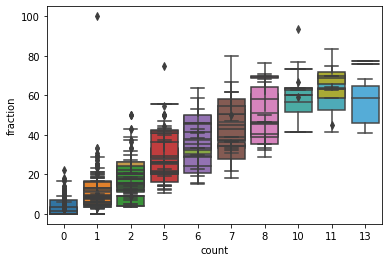

In [128]:
fig, ax = plt.subplots()
cellDict={}
outputDir = project_location + "./output/merfish/tangram/"
for  c in celltypes:
    cellDict["count"]=typeCountDf[c]
    cellDict["fraction"]=deconvolveDf[c]
    df = pd.DataFrame(cellDict)
    sns.boxplot(x='count',y='fraction',data= df,ax=ax)
    fileName= outputDir  + c+".pdf"
    plt.savefig(fileName)

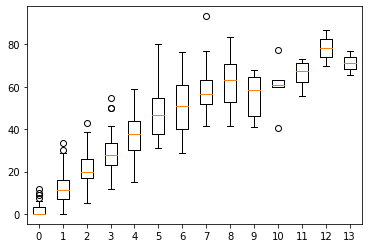

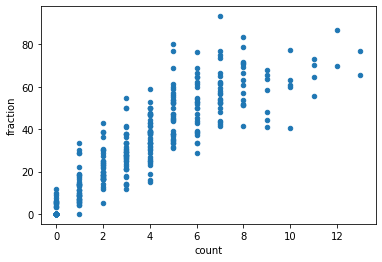

In [130]:
celltypes= ["Inhibitory"]
cellDict={}
for  c in celltypes:
    uniqueCounts= (typeCountDf[c].unique())
    uniqueCounts = np.sort(uniqueCounts)
    for val in uniqueCounts:
        cellDict[val]=[deconvolveDf.iloc[Index][c] for Index  in range(len(deconvolveDf))  if abs(typeCountDf.iloc[Index][c]-val)<0.0000001 ]
    # print(cellDict[0])

    fig, ax  = plt.subplots()
    ax.boxplot(cellDict.values())
    ax.set_xticklabels(cellDict.keys())

    scatterDict={
        "count": typeCountDf[c],
        "fraction":deconvolveDf[c],
    }
    scatterDf=pd.DataFrame(scatterDict)   
    ax1 = scatterDf.plot.scatter(x='count',
                      y='fraction',
                    )
    # pdf = matplotlib.backends.backend_pdf.PdfPages("./output/merfish/tangram2c"+c+".pdf")
    # pdf.savefig(ax)
    # pdf.savefig(ax1)

In [140]:
for i in range(deconvolveDf.shape[0]):
    for j in range(deconvolveDf.shape[1]):
        # if celltype-specific cellcount is zero and deconvolution percentage > threshold
        if typeCountDf.iloc[i,j] == 0 and deconvolveDf.iloc[i,j] > 15:
            print(cellcount.iloc[i][0], deconvolveDf.columns[j], deconvolveDf.iloc[i,j])

7 Excitatory 22.22222222222222
11 Microglia 16.666666666666668
10 Ambiguous 18.181818181818183
9 ODMature1 17.647058823529413
7 Ambiguous 16.666666666666668


In [133]:
cellcount.value_counts()

cellcount
10           55
9            43
11           40
12           35
8            30
13           27
7            22
14           20
15           20
16           10
6             6
5             4
18            4
17            3
4             2
1             1
dtype: int64